# First Twitter App
----
###  1. 소켓으로 전달받은 트윗 데이터 SparkStreamingContext로 태그 수 집계하기
_____

#### findspark 모듈 인스톨 및 실행

In [1]:
pip install findspark

  Using cached findspark-2.0.1-py2.py3-none-any.whl (4.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark

In [3]:
findspark.init()

#### pyspark 라이브러리에서 SparkContext, StreamingContext, SQLContext 불러오기

In [4]:
# May cause deprecation warnings, safe to ignore, they aren't errors
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [5]:
# sparkContext 인스턴스 생성
sc =SparkContext()

In [6]:
# 10초간의 배치(batchInterval)를 사용하여 sparkStreamingContext 인스턴스 생성
ssc = StreamingContext(sc, 10)

# 트윗 태그 수 집계할 SQLContext 인스턴스 생성
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
# 데이터를 입력받을 소켓 스트림 생성
socket_stream = ssc.socketTextStream("127.0.0.1", 5555)

In [8]:
# 스트림 윈도우 20초 간격으로 설정
lines = socket_stream.window( 20 )

In [9]:
# 태그이름, 태그갯수를 저장 할 네임드 튜플 선언
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [10]:
# SQLContext가 처리할 쿼리 작업 지정
( lines.flatMap( lambda text: text.split( " " ) ) #리스트로 분리
  .filter( lambda word: word.lower().startswith("#") ) # 해쉬태그만 추출
  .map( lambda word: ( word.lower(), 1 ) ) # 소문자로 변경
  .reduceByKey( lambda a, b: a + b ) # reduce 연산
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # 네임드 튜플 Tweet에 태그이름, 태그수 저장
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # 개별 Tweet RDD Dataframe에 count수 기준으로 정렬해서 저장 
  .limit(10).registerTempTable("tweets") ) ) # 상위 10개 데이터만 저장한 tweets 테이블 생성

__________
### 2. TweetRead.py 파일 실행하기
__________

#### 시각화를 위한 matplotlib, seaborn 라이브러리 불러오기

In [11]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
# Only works for Jupyter Notebooks!
%matplotlib inline 

In [12]:
# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

#### SparkStreamingContext로 트윗 데이터 받기

In [13]:
ssc.start()

/usr/local/spark/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


---
### 3. Seaborn barplot으로 상위 10개 해쉬태그 시각화
---

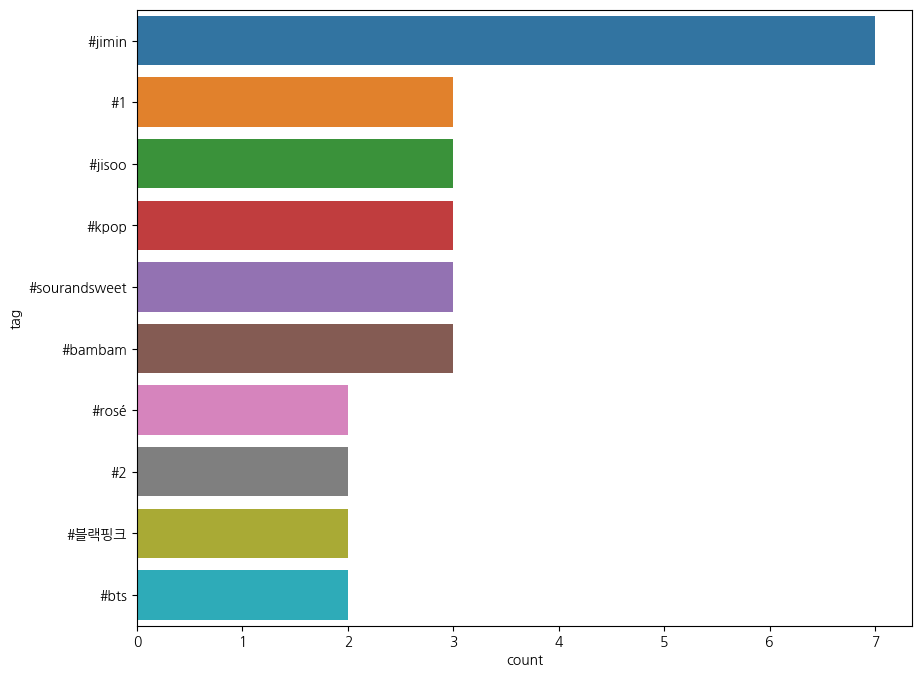

KeyboardInterrupt: 

/usr/local/spark/python/pyspark/sql/dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [17]:
count = 0
while count<10:
    
    time.sleep( 3 )
    #tweets 테이블에서 tag, count 필드만 추출
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    #판다스 dataframe으로 변환
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    #barplot 생성
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count += 1


#### SparkStreamingContext 소켓 닫기

In [12]:
ssc.stop()